In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import altair as alt
from scipy import stats

try:  # if on phy-server local modules will not be found if their directory is not added to PATH
    import sys
    sys.path.append("/silod7/lenz/MPSchleiSediments/analysis/")
    import os
    os.chdir("/silod7/lenz/MPSchleiSediments/analysis/")
except Exception:
    pass

import prepare_data
from dists import compose_dists_df
import outliers
import KDE_utils
import correlations
from components import PCA, PCOA
import plots
import glm
from settings import Config

# alt.renderers.enable('altair_viewer')  # use to display altair charts externally in bgser instead of inline (only activate in non-vega-compatible IDE like pycharm)
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

## Load and prepare data
**Before running, check the computational parameters in settings.py**

Nomenclature:
- *pdd*: particle domain data = data is particle based, meaning one entry (row) corresponds to one particle and one feature (column) corresponds to one property observed for that particle
- *sdd*: sample domain data = data is sample based, meaning one entry (row) corresponds to one sample and one feature (column) corresponds to one property observed for that sample
- *mp*: data on microplastics
- *sed*: data on sediments

In [2]:
# What happened so far: DB extract and blank procedure. Now import resulting MP data from csv
mp_pdd = prepare_data.get_pdd()

# Also import sediment data (sediment frequencies per size bin from master sizer export)
grainsize_iow, grainsize_cau, sed_lower_boundaries = prepare_data.get_grainsizes()

# ...some data wrangling to prepare particle domain data and sample domain data for MP and combine with certain sediment aggregates.
mp_sdd = prepare_data.aggregate_SDD(mp_pdd)
sdd_iow = prepare_data.additional_sdd_merging(mp_sdd)
sdd_cau = pd.read_csv('../data/Metadata_CAU_sampling_log.csv', index_col=0)

Removed 3 samples with less than 19 particles.
Sample
Schlei_S24    18.0
Schlei_S31    12.0
Schlei_S5     12.0
dtype: float64


/home/rob/git/MPSchleiSediments/analysis/prepare_data.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  mp_pdd.columns = mp_pdd.columns.str.replace("[\[( )\]]", "")  # remove brackets from column names


In [3]:
# n = len(mp_pdd)  # number of random samples to be generated from the distributions

# sed_rho_tridist = get_distributed_data('triang', low=1100, peak=2650, high=2800, n=n, plot_bins=20)
# sed_size_tridist = get_distributed_data('triang', low=0.06, peak=30, high=2000, n=n, plot_bins=20)
# sed_life_tridist = get_distributed_data('triang', low=19_952, peak=1_995_262, high=1e9, n=n, plot_bins=20)

# pom_rho_tridist = get_distributed_data('triang', low=800, peak=1000, high=1600, n=n, plot_bins=20)
# pom_size_tridist = get_distributed_data('triang', low=0.2, peak=5, high=2500, n=n, plot_bins=20)
# pom_life_tridist = get_distributed_data('triang', low=16, peak=1259, high=31_623, n=n, plot_bins=20)

# mp_life_tridist = get_distributed_data('triang', low=63, peak=100_000, high=15_848_932, n=n, plot_bins=20)

In [4]:
# from settings import dist_params
# n = len(mp_pdd)  # number of random samples to be generated from the distributions
# plot_bins = 0

# df = pd.DataFrame(dist_params)

# # create empty output dataframe (of)
# of = pd.DataFrame(columns=['particle_type'])

# # loop through rows of sdf and fill odf column 'particle_type' with current index
# # call get_distributed_data for each row and fill odf column 'distribution' with resulting distribution

# for _, row in df.iterrows():
#     if row['particle_type'] not in of['particle_type'].to_list():
#         of = pd.concat([of, pd.DataFrame({'particle_type': row['particle_type'], row['prop']: get_distributed_data(dist_name = row['dist_name'], low=row['low'], peak=row['peak'], high=row['high'], n=n, plot_bins=plot_bins)})],axis=0)
#     else:
#         of.loc[of['particle_type']==row['particle_type'], row['prop']] = get_distributed_data(dist_name = row['dist_name'], low=row['low'], peak=row['peak'], high=row['high'], n=n, plot_bins=plot_bins)
#         # of = pd.concat([of, pd.DataFrame({'particle_type': row['particle_type'], row['prop']: get_distributed_data(dist_name = row['dist_name'], low=row['low'], peak=row['peak'], high=row['high'], n=n, plot_bins=plot_bins)})],axis=1)    

# of.reset_index(drop=True, inplace=True)

triang


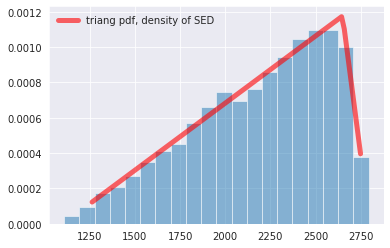

triang


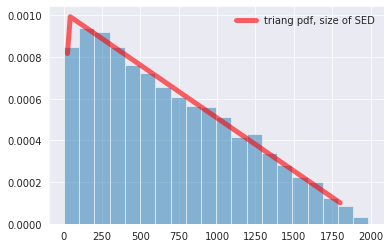

triang


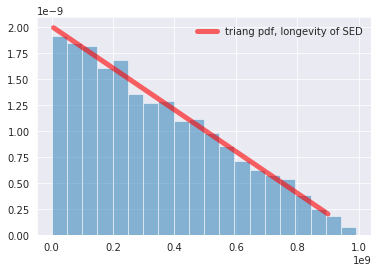

triang


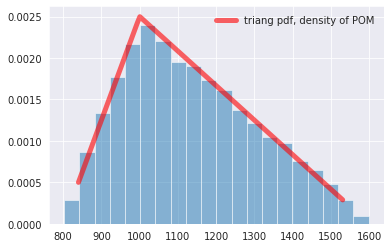

triang


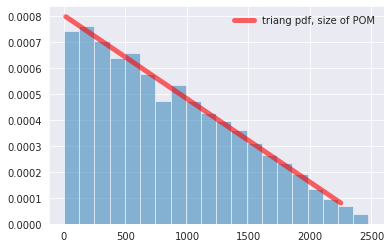

triang


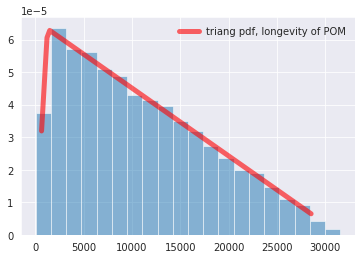

triang


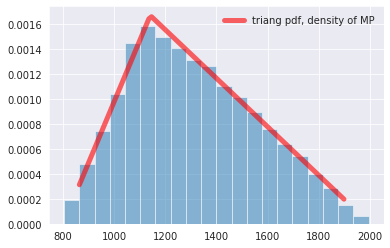

triang


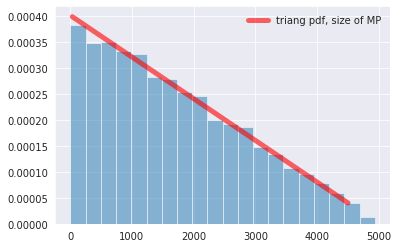

triang


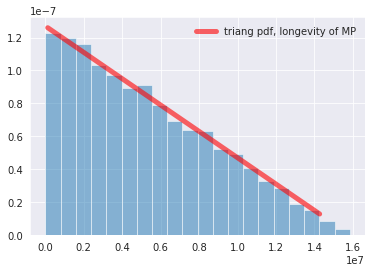

In [5]:
contour_particles = compose_dists_df(n=len(mp_pdd), plot_bins=0)

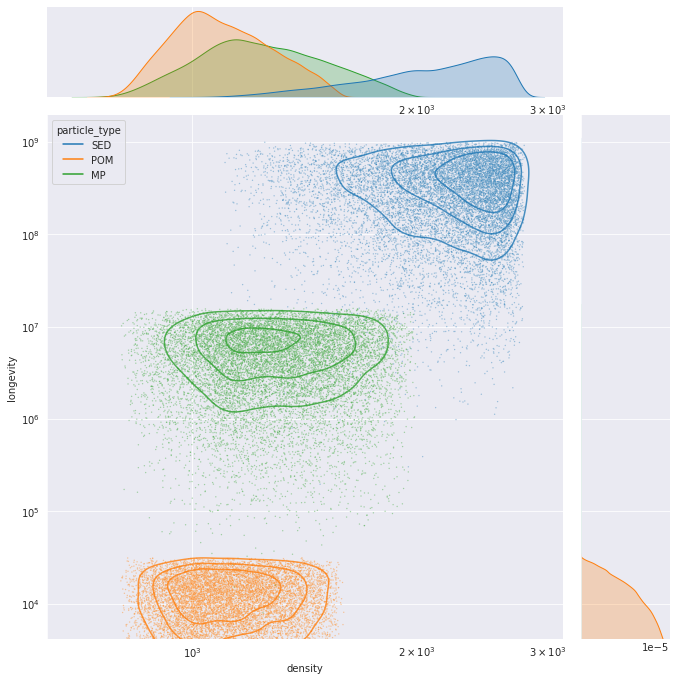

In [7]:
# create a dataframe with a column for particle type ['sed', 'pom', 'MP'], one column containing rho (from sed_rho_tridist, pom_rho_tridist and mp_pdd['density'], respectively) and one column containing size (from sed_size_tridist, pom_size_tridist and mp_pdd['size_geo_mean'], respectively).
# conMP = pd.DataFrame({'particle_type': ['MP'] * len(mp_pdd), 'density': mp_pdd['density'], 'size': mp_pdd['size_geom_mean'], 'longevity': mp_life_tridist})
# conSED = pd.DataFrame({'particle_type': ['SED'] * len(sed_rho_tridist), 'density': sed_rho_tridist, 'size': sed_size_tridist, 'longevity': sed_life_tridist})
# conPOM = pd.DataFrame({'particle_type': ['POM'] * len(pom_rho_tridist), 'density': pom_rho_tridist, 'size': pom_size_tridist, 'longevity': pom_life_tridist})
# # conMP = pd.DataFrame({'particle_type': ['MP'] * len(mp_pdd), 'density': mp_pdd['density'], 'log(size)': np.log10(mp_pdd['size_geom_mean'])})
# # conSED = pd.DataFrame({'particle_type': ['SED'] * len(sed_rho_tridist), 'density': sed_rho_tridist, 'log(size)': np.log10(sed_size_tridist)})
# # conPOM = pd.DataFrame({'particle_type': ['POM'] * len(pom_rho_tridist), 'density': pom_rho_tridist, 'log(size)': np.log10(pom_size_tridist)})
# contour_particles = pd.concat([conSED,conPOM,conMP]).reset_index(drop=True)
# # contours = plots.px_contour_plot(mp_pdd, 'density', 'size_geom_mean')
# # contours.show()

plots.sns_contour_plot(contour_particles, 'density', 'longevity', 'particle_type', log=(True,True), figsize=(10,10))
# plots.sns_contour_plot(sed_rho_tridist, sed_size_tridist, cmap = 'Greys', xlog=False, ylog=False, thresh=0)
# plots.sns_contour_plot(pom_rho_tridist, pom_size_tridist, cmap = 'Greens', xlog=True, ylog=True, thresh=1/n*10)
# plots.sns_contour_plot(mp_pdd['density'], mp_pdd['size_geom_mean'], cmap='Reds', xlog=True, ylog=True, thresh=0.1)

In [ ]:
sdd_iow['pred_ConcentrationA500'] = np.exp(0.505 + 0.0452 * sdd_iow['perc MUD'] + 0.0249 * 2.22 * sdd_iow['TOC'])

alt.Chart(sdd_iow).mark_point().encode(x='ConcentrationA500',y='pred_ConcentrationA500',tooltip='Sample')

## Polymer composition analysis

In [ ]:
comp = prepare_data.aggregate_SDD(mp_pdd.groupby(['Sample', 'polymer_type'])).merge(sdd_iow[['Sample', 'Dist_WWTP', 'regio_sep']], on='Sample')
# comp['polymer_type'] = comp.Shape

com = comp.pivot(index='Sample', columns=['polymer_type'], values=['Concentration']).droplevel(0,axis=1).fillna(0)

In [ ]:
scor, load, expl = PCOA(com, 2)  # call either PCA or PCOA

In [ ]:
pc_plot = plots.biplot(scor, load, expl, sdd_iow, 'PC1', 'PC2', sc='regio_sep', lc='polymer_type', ntf=7, normalise=True)
pc_plot

In [ ]:
# import plotly.express as px
# import plotly.io as pio
# pio.renderers.default = 'sphinx_gallery'
# fig = px.scatter(scor.rename_axis(index='Sample').reset_index().merge(comp[['Sample', 'Dist_WWTP', 'regio_sep']], on='Sample'),
#                     x='PC1',
#                     y='PC2',
#                     #z='PC3',  # when uncommenting: use px.scatter_3d instead of px.scatter
#                     color='Dist_WWTP',
#                     color_continuous_scale='Greys',
#                     hover_name="Sample")

# # resize markers
# fig.update_traces(marker=dict(size=10,
#                               line=dict(width=2,
#                                         color='DarkSlateGrey')),
#                   selector=dict(mode='markers'))

# # change size and move colorbar
# fig.update_layout(autosize=False, width=1000, height=800,
#                   coloraxis_colorbar=dict(yanchor="top", y=1, x=0, ticks="outside"))
# fig.show()

## MP particle size distributions

*This calculates probability density distributions for MP sizes. These are used to estimate the abundances of MP of specific size ranges, which can then be investigated for correlations to environmental parameters such as TOC or sediment grain size properties.*
**Before running, check the computational parameters in settings.py**

In [ ]:
# KDEs for probability of finding a MP particle in a specific size bin are calculated.
size_pdfs = KDE_utils.per_sample_kde(mp_pdd, sed_lower_boundaries)

In [ ]:
# Get MP concentrations for each single-step size bin
mp_size_conc = KDE_utils.probDens2conc(size_pdfs, mp_sdd)

In [ ]:
# MP and sediment abundances per size bin are equalised (only samples and bins contained in both of the are kept).
# They are then melted and merged into MPsedMelted.
mp_size_conc, grainsize_iow, mp_sed_melt = prepare_data.equalise_mp_and_sed(mp_size_conc, grainsize_iow)

## Sediment size bin dimension reduction

In [ ]:
# PCA

# SEDpc, SEDexp, SEDload = sed_pca(SEDext.T)
# sedpc, sedexp, sedload = sed_pca(grainsize_iow)

# To see a loadings plot use:
# sedload_df = pd.DataFrame(sedload, columns=['PC1', 'PC2', 'PC3'], index = np.unique(np.concatenate(np.char.split(sed_size_freqs.index.values.astype(str), '_')).ravel().astype(int))[:-1]).T
# sedload_df.T.plot()  # x-axis corresponds to lower boundary of size bins

In [ ]:
# PCoA

# sedpco = sed_pcoa(grainsize_iow, num_coords = 2)
# sedpco = sed_pcoa(grainsize_iow.append(grainsize_cau), num_coords = 2)
sedpco, sedloads, sedexpl = PCOA(grainsize_iow, num=2)

# Plot PCo1 and PCo2
# alt.Chart(sedpco.merge(sdd_iow, left_index=True, right_on='Sample').reset_index()).mark_point().encode(
#     x='PC1',
#     y='PC2',
#     color='D50',
#     tooltip='index'
# )

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set_theme(style="white")

# df = sedpco.merge(sdd_iow, left_index=True, right_on='Sample')
# corrmat = df.corr()

# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corrmat, dtype=bool))

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(40, 40))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 10, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corrmat, mask=mask, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
# alt.Chart(df).mark_circle().encode(
#     alt.X(alt.repeat("column"), type='quantitative'),
#     alt.Y(alt.repeat("row"), type='quantitative'),
#     color='regio_sep:N',
#     tooltip=['Sample']
# ).properties(
#     width=200,
#     height=200
# ).repeat(
#     row=['D50', 'smaller63', 'MoM_ari_MEAN', 'MoM_ari_SORTING', 'MoM_ari_SKEWNESS', 'MoM_ari_KURTOSIS', 'MoM_geo_MEAN', 'MoM_geo_SORTING',
#        'MoM_geo_SKEWNESS', 'MoM_geo_KURTOSIS', 'MoM_log_MEAN', 'MoM_log_SORTING', 'MoM_log_SKEWNESS', 'MoM_log_KURTOSIS',
#        'FW_geo_MEAN', 'FW_geo_SORTING', 'FW_geo_SKEWNESS', 'FW_geo_KURTOSIS', 'FW_log_MEAN', 'FW_log_SORTING', 'FW_log_SKEWNESS', 'FW_log_KURTOSIS',
#        'MODE 1 (µm)', 'MODE 2 (µm)', 'MODE 3 (µm)', 'D10 (µm)', 'D50 (µm)', 'D90 (µm)', '(D90 div D10) (µm)', '(D90 - D10) (µm)', '(D75 div D25) (µm)', '(D75 - D25) (µm)', 'perc GRAVEL', 'perc SAND', 'perc MUD',
#        'perc V COARSE SAND', 'perc COARSE SAND', 'perc MEDIUM SAND', 'perc FINE SAND', 'perc V FINE SAND', 'perc V COARSE SILT', 'perc COARSE SILT',
#        'perc MEDIUM SILT', 'perc FINE SILT', 'perc V FINE SILT', 'perc CLAY', 'Dx 50', 'TOC', 'Hg'],
#     column=['PC1', 'PC2']
# ).interactive()

## Modelling

### GLM model

In [ ]:
# Create a generalized linear model (GLM) to predict the microplastic concentration from the predictors

glm_input = sdd_iow.merge(sedpco, left_on='Sample', right_index=True)

glm_res = glm.glm(glm_input)
print(glm_res.summary())
# glm_res.predict(glm_input.iloc[[0]])

### XGBoosting Model

In [ ]:
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [ ]:
# xgboost model

data = sdd_iow.merge(sedpco, left_on='Sample', right_index=True).set_index('Sample').copy()

y = data.pop('Concentration') # Target vector in pd.Series format
X = data.loc[:, ['MoM_ari_MEAN', 'MoM_ari_SORTING',
       'MoM_ari_SKEWNESS', 'MoM_ari_KURTOSIS', 'MoM_geo_MEAN',
       'MoM_geo_SORTING', 'MoM_geo_SKEWNESS', 'MoM_geo_KURTOSIS',
       'MoM_log_MEAN', 'MoM_log_SORTING', 'MoM_log_SKEWNESS',
       'MoM_log_KURTOSIS', 'perc GRAVEL', 'perc SAND',
       'perc MUD', 'perc V COARSE SAND', 'perc COARSE SAND', 'perc MEDIUM SAND',
       'perc FINE SAND', 'perc V FINE SAND', 'perc V COARSE SILT',
       'perc COARSE SILT', 'perc MEDIUM SILT', 'perc FINE SILT',
       'perc V FINE SILT', 'perc CLAY', 'OM_D50', 'TOC', 'Hg', 'Dist_WWTP',
       'PC1', 'PC2']] # Feature matrix in pd.DataFrame format

In [ ]:
# Making train and test sets for both X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, shuffle=True)
# Instantiate an XGBoost object with hyperparameters
xgb_reg = xgb.XGBRegressor(col_sample=10, alpha=0.5, max_depth=2, n_estimators=1000, n_jobs=2,
                           objective='reg:squarederror', booster='gbtree',
                           random_state=42, learning_rate=0.05)

In [ ]:
# Train the model with train data sets
xgb_reg.fit(X_train, y_train)

y_pred = xgb_reg.predict(X_test) # Predictions
y_true = y_test # True values

In [ ]:
MSE = mse(y_true, y_pred)
RMSE = np.sqrt(MSE)

R_squared = r2_score(y_true, y_pred)

print("\nRMSE: ", np.round(RMSE, 2))
print()
print("R-Squared: ", np.round(R_squared, 2))

In [ ]:
# Visualise results
from shapash.explainer.smart_explainer import SmartExplainer

y_pred_as_series = pd.Series(y_pred, index=X_test.index, dtype=int)

xpl = SmartExplainer() # Creating xpl object
xpl.compile(x=X_test, model=xgb_reg, y_pred=y_pred_as_series)
app = xpl.run_app() # Launch the app

## MP and sediment size range combination correlations

In [ ]:
# Sum abundances in size bins for all possible combinations. Basically create all possible rebinnings and stack them into one DF
# MPext = prepare_data.combination_sums(mp_size_conc.copy().T).T  # TODO: using transposed df's here, because combination_sums is not yet turned around: it takes features in rows and samples in columns...
SEDext= prepare_data.combination_sums(grainsize_cau.copy().T).T

### Altair size range correlation (PC~Sed)

In [ ]:
pc='PC2'

pc2gs_corr = pd.DataFrame(SEDext.corrwith(sedpco[pc], method='pearson'), columns=['pearson'])
pc2gs_corr['spearman'] = SEDext.corrwith(sedpco[pc], method='spearman')
pc2gs_corr['size_low'] = pc2gs_corr.index.str.split('_').str[0].astype(float)
pc2gs_corr['size_up'] = pc2gs_corr.index.str.split('_').str[1].astype(float)
pc2gs_corr['size_dif'] = pc2gs_corr['size_up'] - pc2gs_corr['size_low']

df = sedpco.join(SEDext).melt(id_vars=['PC1','PC2'], ignore_index=False)
df['size_low'] = df.variable.str.split('_').str[0].astype(float)
df['size_up'] = df.variable.str.split('_').str[1].astype(float)
df['size_dif'] = df['size_up'] - df['size_low']

x_init = float(SEDext.iloc[:,pc2gs_corr.pearson.argmax()].name.split('_')[0])
y_init = float(SEDext.iloc[:,pc2gs_corr.pearson.argmax()].name.split('_')[1])
pts = alt.selection(type="single", encodings=['x','y'], init={'x': x_init, 'y': y_init})

heatmap = alt.Chart(pc2gs_corr.reset_index()).mark_circle().encode(
    x = alt.X('size_low', scale=alt.Scale(type='log')),
    y = alt.Y('size_up', scale=alt.Scale(type='log')),
    color = alt.condition(alt.datum.pearson == pc2gs_corr.pearson.max(),
                          alt.value('orange'),
                          alt.Color('pearson', scale=alt.Scale(scheme='redblue', domain=[-1,1]))),
    # size = alt.condition(alt.datum.pearson == pc2gs_corr.pearson.max(),
    #                       alt.value('10'),
    #                       alt.value('5')),
    tooltip = ['pearson', 'spearman', 'size_low', 'size_dif', 'size_up']
).add_selection(pts
).properties(
    width=600,
    height=600
).interactive()


scatter = alt.Chart(df.reset_index()).mark_point().encode(
    x=pc,
    y='value',
    tooltip='index'
)

RegLine = scatter.transform_regression(
    pc, 'value', method="linear",
).mark_line(
    color="red"
)

RegParams = scatter.transform_regression(
    pc, 'value', method="linear", params=True
).mark_text(align='left', lineBreak='\n').encode(
    x=alt.value(20),  # pixels from left
    y=alt.value(20),  # pixels from top
    text='params:N'
).transform_calculate(
    params='"R² = " + round(datum.rSquared * 100)/100 + \
    "      y = " + round(datum.coef[1] * 100)/100 + "x" + " + " + round(datum.coef[0] * 10)/10'
)

text0 = scatter.mark_text(align='left', lineBreak='\n').encode(
    x=alt.value(20),  # pixels from left
    y=alt.value(60),  # pixels from top
    text=alt.value('Size bin:')
)

text1 = scatter.mark_text(align='left', lineBreak='\n').encode(
    x=alt.value(20),  # pixels from left
    y=alt.value(80),  # pixels from top
    text='variable'
)

scat_plot = alt.layer(
    scatter, RegLine, RegParams, text0, text1
).transform_filter(pts
).properties(
    width=600,
    height=600
)

alt.hconcat(
    heatmap,
    scat_plot
).resolve_legend(
    color="independent"
)

### Altair size range correlation (MP~Sed)

In [ ]:
MPsedExt = prepare_data.merge_size_ranges(MPext, 'MP', SEDext, 'SED', cart_prod=True)

In [ ]:
brush1 = alt.selection_interval(name="brush1", encodings=['y'])
brush2 = alt.selection_interval(name="brush2", encodings=['x'])

step = sed_lower_boundaries[1] - sed_lower_boundaries[0]

scatter = alt.Chart(MPsedExt
).transform_calculate(
    b1l=f'floor((isDefined(brush1.y) ? (brush1.y[0][0]) : 1) / {step}) * {step}',
    b1u=f'ceil((isDefined(brush1.y) ? (brush1.y[0][1]) : 1) / {step}) * {step}',
    b2l=f'floor((isDefined(brush2.x) ? (brush2.x[0][0]) : 1) / {step}) * {step}',
    b2u=f'ceil((isDefined(brush2.x) ? (brush2.x[0][1]) : 1) / {step}) * {step}',
).mark_point().encode(
    x = 'SED',
    y = 'MP',
    tooltip = 'sample:N'
).transform_filter(
    '(datum.lower_MP >= datum.b1l) &&'
    '(datum.upper_MP <= datum.b1u) &&'
    '(datum.lower_SED >= datum.b2l) &&'
    '(datum.upper_SED <= datum.b2u)'
)
    

RegLine = scatter.transform_regression(
    'SED', 'MP', method="linear",
).mark_line(
    color="red"
)


RegParams = scatter.transform_regression(
    'SED', 'MP', method="linear", params=True
).mark_text(align='left', lineBreak='\n').encode(
    x=alt.value(120),  # pixels from left
    y=alt.value(20),  # pixels from top
    text='params:N'
).transform_calculate(
    params='"r² = " + round(datum.rSquared * 100)/100 + \
    "      y = " + round(datum.coef[1] * 100)/100 + "x" + " + " + round(datum.coef[0] * 10)/10'
)


MP = alt.Chart(MPsedExt).mark_line().encode(
    x = 'mean(MP)',
    y = alt.X('lower_MP', scale=alt.Scale(type='linear'))
).transform_filter(
    '(datum.lower_MP == datum.lower_SED) && \
     (datum.upper_MP == datum.upper_SED)'
).add_selection(
    brush1
).properties(
    height = 300,
    width = 100
)


sed = alt.Chart(MPsedExt).mark_line().encode(
    x = alt.X('lower_SED', scale=alt.Scale(type='linear')),
    y = 'mean(SED)'
).transform_filter(
    '(datum.lower_MP == datum.lower_SED) &&'
    '(datum.upper_MP == datum.upper_SED)'
).add_selection(
    brush2
).properties(
    height = 100,
    width = 400
)


MP | (scatter + RegLine + RegParams) & sed

# chart = MP | scatter & sed
# chart#.save('chart.json')

### Size range correlation matrix (MP~Sed)

In [ ]:
# Calculate a correlation matrix containing Pearson correlation coefficients for all combinations of any original or summed bins of MP and sediments.
corrMat = np.corrcoef(MPext,SEDext)
corrMat = corrMat[:len(MPext), len(SEDext):]  # only take upper right quadrant of correlation matrix

corrMatDF = pd.DataFrame(corrMat, index=MPext.index, columns=SEDext.index)  # turn np array into df
# corrMatDF.rename('MP_{}'.format, axis=0, inplace=True)  # add a prefix for 'MP' to each row label
# corrMatDF.rename('SED_{}'.format, axis=1, inplace=True)  # add a prefix for 'sediment' to each column label
corrMatDF.index.name = 'MP'
corrMatDF.columns.name = 'SED'

### Cross-Correlation

In [ ]:
# Run a cross-correlation for each sample between MP and sediment size distribution curve shapes.
crosscorr_results = pd.DataFrame()

for label, content in df_range_conc.items():
    datax = content
    datay = grainsize_iow[label]
    #best = correlations.crosscorr(datax, datay)
        
#     lags = range(-int(len(datax)/2), int(len(datax)/2)+1)
    lags = range(-50,0)
    df_r = pd.DataFrame(lags, columns = ['shifted'])
    
#     r_pear = [datax.corr(datay.shift(lag)) for lag in lags]
#     df_r['pearson_r'] = r_pear
    r_spear = [stats.spearmanr(np.array(datax),np.array(datay.shift(lag)), nan_policy = 'omit') for lag in lags]
    df_r['spearman_r'] = r_spear
    
    
    best = df_r.copy().loc[df_r['spearman_r'] == df_r['spearman_r'].max()]
    best['Sample'] = label
    crosscorr_results = crosscorr_results.append(best)

## MP-to-Scalar correlation (e.g. TOC)

In [ ]:
alt.Chart(sdd_iow).mark_point().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    y = 'Concentration',
    color = 'Regio_Sep',
    tooltip = 'Sample'
).repeat(
    column=['D50', 'TOC', 'Dist_WWTP', 'Mass', 'Split']
).interactive()

In [ ]:
import plotly.express as px
fig = px.scatter_3d(sdd_iow, x='Dist_WWTP', y='D50', z='Concentration',
                    color='TOC', symbol='regio_sep', hover_name="Sample",
                    color_continuous_scale=px.colors.sequential.turbid_r)

# resize markers
fig.update_traces(marker=dict(size=4,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

# change size and move colorbar
fig.update_layout(autosize=False, width=1000, height=800,
                  coloraxis_colorbar=dict(yanchor="top", y=1, x=0, ticks="outside"))
fig.show()

In [ ]:
# Calculate correlation between all size bins (or their summed up combinations) of MP abundances and a scalar predictor.
# Possible predictors are: 'TOC', 'Hg', 'Dist_WWTP' or different sediment grain size properties (D50, below 63, etc.). See column labels of sdd_MP_sed for a full list.
bestLower, bestUpper, df_r = correlations.predictorcorr(df_range_conc, sdd_iow.set_index('Sample'), 'TOC')

In [ ]:
# Heatmap correlation coefficients from the single predictor correlation
alt.renderers.enable('html')

alt.Chart(df_r).mark_point().encode(
    x='lower_size',
    y='upper_size',
    color=alt.Color("r", scale=alt.Scale(domain=[0.5, 0.6])),
    tooltip=['r', 'lower_size', 'upper_size']
).properties(
    width=800,
    height=800
)

In [ ]:
#####USED only for testing external function inside NB: #####
step = (Config.upper_size_limit - Config.lower_size_limit) / Config.kde_steps
df_r = pd.DataFrame(columns=['lower_size', 'upper_size', 'r', 'p'])

for i in [10]:
    for j in [1000]:
        size_sum = size_pdfs.loc[(size_pdfs.x_d >= i) & (size_pdfs.x_d < j)].sum()
        size_sum.drop('x_d', inplace=True)
        range_prob = size_sum * step
        range_conc = range_prob * sdd_iow.set_index('Sample').Concentration

        r = stats.pearsonr(range_conc, sdd_iow.set_index('Sample').TOC)
        df_r.loc[len(df_r)] = [i, j, r[0], r[1]]
        print(f'Correlating TOC with size range            [{i},        {j}]                ', end="\r", flush=True)

print(df_r.loc[df_r.r == df_r.r.max()])
bestLower, bestUpper = df_r.loc[df_r.r == df_r.r.max()].iloc[0, 0:2]

In [ ]:
# Property-property-plot with MP against single predictor incl. reg line 
kd = alt.Chart(pd.DataFrame([range_conc, sdd_iow.set_index('Sample').TOC]).T.reset_index()).mark_point().encode(
    x='TOC',
    y='Unnamed 0',
    color='index',
    tooltip='index'
)

Reg_Line = kd.transform_regression('TOC', 'Unnamed 0', method="linear",
                                  ).mark_line(color="red")

Reg_Params = kd.transform_regression('TOC', 'Unnamed 0', method="linear", params=True
                                    ).mark_text(align='left', lineBreak='\n').encode(
        x=alt.value(120),  # pixels from left
        y=alt.value(20),  # pixels from top
        text='params:N'
    ).transform_calculate(
        params='"r² = " + round(datum.rSquared * 100)/100 + \
    "      y = " + round(datum.coef[0] * 10)/10 + " + e ^ (" + round(datum.coef[1] * 10000)/10000 + "x" + ")" + \n + " "'
    )

kd + Reg_Line + Reg_Params

In [ ]:
daf = grainsize_iow.reset_index().melt(id_vars='index', value_name='value')
daf['size'] = daf['index'].str.split('_').str[0]
daf['category'] = 'sediment'

daff = df_range_conc.reset_index().melt(id_vars='index', value_name='value')
daff['size'] = daf['index'].str.split('_').str[0]
daff['category'] = 'MP'

df = pd.concat([daf, daff]).drop(columns=['index'])
# df = daf.merge(daff, on =['sample', 'size', 'index']).drop(columns=['index'])

In [ ]:
input_dropdown = alt.binding_select(options=list(df['sample'].unique()), name='select sample ')
selection = alt.selection_single(fields=['sample'],
                                 bind=input_dropdown,
                                 #init={'select_': 'Schlei_S8'}
                                )

base = alt.Chart(df).mark_line().encode(
    x=alt.X('size:Q'),
    y=alt.Y('value:Q'),
    color='category',
#     shape='category',
#     detail='category'
# ).transform_window(
#     cuml='sum(value)',
#     groupby=['sample']
).transform_filter(
    alt.FieldRangePredicate(field='size', range=[50, 990])
# ).properties(
#     width=180,
#     height=180
# ).facet(
#     facet='sample',
#     columns=6
# ).resolve_scale(
#     y='independent'
)


mps = base.mark_line(color='blue').transform_filter(
    alt.FieldEqualPredicate(field='category', equal='MP')
)
seds = base.mark_line(color='yellow').transform_filter(
    alt.FieldEqualPredicate(field='category', equal='sediment')
)

alt.layer(mps, seds).resolve_scale(
    y = 'independent'
).add_selection(
    selection
).transform_filter(
    selection
)


In [ ]:
base = alt.Chart(df).encode(
    alt.X('size:Q', axis=alt.Axis(title=None))
).properties(
    width=180,
    height=180
)

mps = base.mark_line(stroke='#57A44C', interpolate='monotone').encode(
    alt.Y('MP:Q', axis=alt.Axis(title='MP', titleColor='#57A44C'))
)

seds = base.mark_line(stroke='#5276A7', interpolate='monotone').encode(
    alt.Y('sediment:Q', axis=alt.Axis(title='sediment', titleColor='#5276A7'))
)

alt.layer(mps, seds).resolve_scale(
    y = 'independent'
).properties(
    width=180,
    height=180
).facet(
    facet='sample',
    columns=6
).resolve_scale(
    y='independent'
)

In [ ]:
df = daf.shift(100).merge(daff, on =['sample', 'size', 'index']).drop(columns=['index'])
alt.Chart(df).mark_point().encode(
    x=alt.X('value_x', scale=alt.Scale(type='linear')),
    y=alt.X('value_y', scale=alt.Scale(type='linear')),
    color=alt.Color('size:Q', scale=alt.Scale(scheme="viridis"))
).properties(
    width=150,
    height=150
).facet(
    facet='sample',
    columns=6
).resolve_scale(
    y='independent',
    x='independent'
)

In [ ]:
data = pd.DataFrame({
    'x': range(9),
    'y': [1, 2, 3, 4, 5, 4, 3, 2, 1]
})

brush = alt.selection_interval(name="brush", encodings=['x'])
alt.Chart(data).mark_line().add_selection(brush).transform_calculate(
    scaled_by_brush_width='datum.y * (isDefined(brush.x) ? (brush.x[1] - brush.x[0]) : 1)'
).encode(
    x='x:Q',
    y='scaled_by_brush_width:Q'
)